# Exercise 3: Two-Strain Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/epistorm/tech-transfer-epydemix/blob/main/sessions/session-4/exercises/python/exercise_3_two_strains.ipynb)

**Objective:** Model the emergence of a more transmissible variant using a multi-strain SIR model.

**Skills practiced:**
- Designing complex compartmental structures
- Using `override_parameter` for delayed strain emergence
- Interpreting multi-strain dynamics

In [ ]:
# Colab installation (skip if running locally)
import sys, os, subprocess
if "google.colab" in sys.modules or os.getenv("COLAB_RELEASE_TAG"):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-r",
                    "https://raw.githubusercontent.com/epistorm/epydemix/refs/heads/main/tutorials/colab_requirements.txt"])

## Model Structure

We model two strains where strain 2 is more transmissible:

**Compartments:** S, I₁, I₂, R₁, R₂

**Transitions:**
- S + I₁ → 2I₁ (rate β) — infection with strain 1
- S + I₂ → 2I₂ (rate β·ψ) — infection with strain 2 (ψ > 1)
- R₁ + I₂ → I₂ + R₂ (rate β·ψ·γ) — reinfection of R₁ by strain 2
- I₁ → R₁ (rate μ) — recovery from strain 1
- I₂ → R₂ (rate μ) — recovery from strain 2

**Parameters:**
- β = 0.20 (base transmission rate)
- μ = 0.1 (recovery rate)
- ψ = 1.5 (strain 2 is 50% more transmissible)
- γ = 0.4 (R₁ individuals have 60% protection against strain 2)

## Task 1: Implement the Two-Strain Model

In [24]:
from epydemix import EpiModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Dark2")

def create_two_strain_model(psi=1.5, gamma=0.4, beta=0.020, mu=0.1):
    """Create a two-strain SIR model.
    
    Args:
        psi: Transmissibility advantage of strain 2 (>1 means more transmissible)
        gamma: Relative susceptibility of R1 to strain 2 (0-1)
        beta: Base transmission rate
        mu: Recovery rate (same for both strains)
    """
    # Create the model with compartments S, I1, I2, R1, R2
    model = EpiModel(
        name = 'Two-Strain SIR Model',
        compartments = ['S','I1','I2','R1','R2']
    )
    
    # Add transitions
    # S + I1 → 2I1 (infection with strain 1)
    model.add_transition(
        source = 'S', target = 'I1',
        params = ('beta','I1'), kind = 'mediated'
    )
    
    # S + I2 → 2I2 (infection with strain 2, more transmissible)
    # Hint: use params=('beta*psi', 'I2')
    model.add_transition(
        source = 'S', target = 'I2',
        params = ('beta*psi','I2'), kind = 'mediated'
    )
    
    # R1 + I2 → I2 + R2 (reinfection: R1 individuals can be infected by strain 2)
    # Hint: use params=("beta*psi*gamma", "I2")
    model.add_transition(
        source = "R1", target = "I2",
        params = ('beta*psi*gamma', 'I2'), kind = 'mediated'
    )
    
    # I1 → R1 (recovery from strain 1)
    model.add_transition(
        source = 'I1', target = 'R1',
        params = 'mu1', kind = 'spontaneous'
    )
    
    # I2 → R2 (recovery from strain 2)
    model.add_transition(
        source = 'I2', target = 'R2',
        params = 'mu2', kind = 'spontaneous'
    )
    
    # TODO: Set parameters (beta, psi, gamma, mu1, mu2)
    model.add_parameter('beta', beta)    # transmission rate
    model.add_parameter('mu1', mu)       # 1/10 days recovery rate
    model.add_parameter('mu2', mu)       # 1/10 days recovery rate
    model.add_parameter('psi', psi)      # strain 2 is 1.5 times as infective
    model.add_parameter('gamma', gamma)  # people infected by 1 protected wrt 2
    
    return model

# Create the model
model = create_two_strain_model(psi=1.5, gamma=0.4)
print(model)

EpiModel(name='Two-Strain SIR Model')
Compartments: 5
  S, I1, I2, R1, R2
Transitions: 5
  Transitions between compartments:
    S -> I1, params: ('beta', 'I1') (kind: mediated)
    S -> I2, params: ('beta*psi', 'I2') (kind: mediated)
    R1 -> I2, params: ('beta*psi*gamma', 'I2') (kind: mediated)
    I1 -> R1, params: mu1 (kind: spontaneous)
    I2 -> R2, params: mu2 (kind: spontaneous)
Parameters: 5
  Model parameters:
    beta: 0.02
    mu1: 0.1
    mu2: 0.1
    psi: 1.5
    gamma: 0.4
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



In [25]:
# Add population
from epydemix.population import load_epydemix_population
population = load_epydemix_population("United_States_Michigan")
model.set_population(population)

## Task 2: Delay Strain 2 Emergence

Use `override_parameter` to "turn off" strain 2 for the first 30 days by setting its transmissibility (ψ) and recovery rate (μ₂) to zero.

**Hint:** 
```python
model.override_parameter(
    start_date="2025-01-01",
    end_date="2025-01-31",
    parameter_name="psi",
    value=0.0
)
```

In [26]:
# Override psi to 0 for the first 30 days
model.override_parameter(
    start_date = '2025-01-01', end_date = '2025-01-31',
    parameter_name = 'psi',
    value = 0
)

# Override mu2 to 0 for the first 30 days
model.override_parameter(
    start_date = '2025-01-01', end_date = '2025-01-31',
    parameter_name = 'mu2',
    value = 0
)

## Task 3: Simulate and Visualize

Run simulations for 6 months with initial conditions seeding both strains.

In [27]:
# TODO: Run simulations with initial conditions
# Use initial_conditions_dict to set:
# - S: population - 20
# - I1: 10 (strain 1 infected)
# - I2: 10 (strain 2 infected, but dormant until day 30)
# - R1: 0
# - R2: 0

results = model.run_simulations(
    start_date = '2025-01-01',
    end_date = '2025-06-30',
    Nsim = 100,
    initial_conditions_dict = {
        'S': population.Nk.sum() - 20,
        'I1': 10, 'I2': 10,
        'R1': 0, 'R2': 0
    }
)

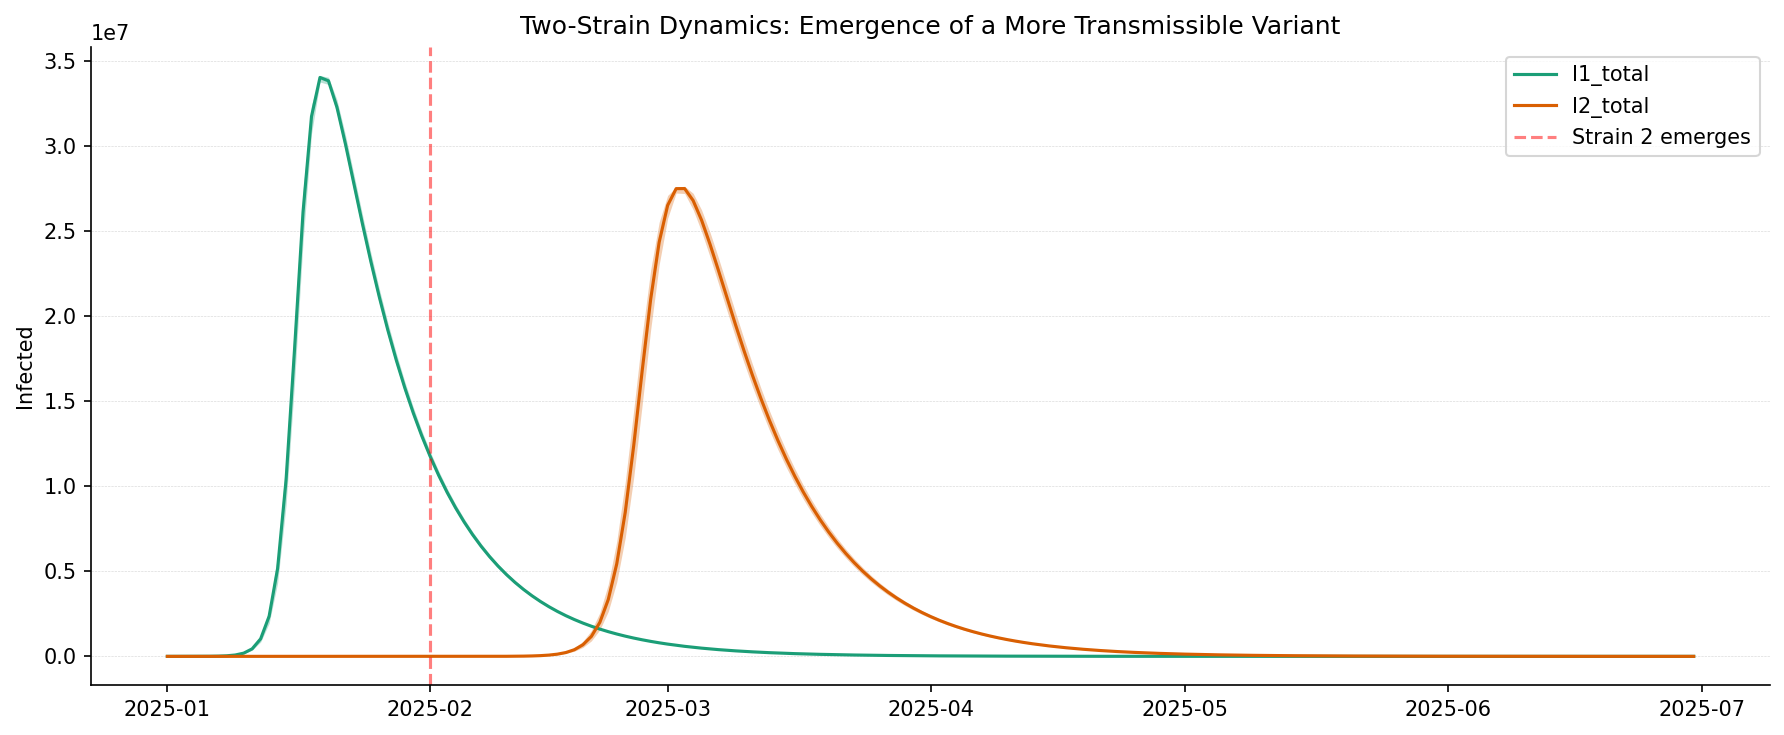

In [28]:
from epydemix.visualization import plot_quantiles
import pandas as pd

# Get quantiles and plot I1 and I2 over time
df_quantiles = results.get_quantiles_compartments()

fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

# Plot strain 1 (I1_total)
plot_quantiles(
    df_quantiles, ax = ax,
    columns = ['I1_total','I2_total'],
    legend_loc = "upper right"
)

# Mark emergence date
ax.axvline(pd.to_datetime("2025-02-01"), color="red", linestyle="--", alpha=0.5, label="Strain 2 emerges")

ax.set_title("Two-Strain Dynamics: Emergence of a More Transmissible Variant")
ax.set_ylabel("Infected")
ax.legend()

plt.tight_layout()

## Task 4: Experiments

### Experiment A: Effect of Emergence Timing

What happens if strain 2 emerges earlier (day 15) vs. later (day 45)?

In [29]:
def run_with_emergence_day(emergence_day):
    """Run simulation with strain 2 emerging on a specific day."""
    model = create_two_strain_model(psi = 1.5, gamma = 0.4)
    population = load_epydemix_population("United_States_Michigan")
    model.set_population(population)
    
    # Calculate emergence date
    from datetime import datetime, timedelta
    start = datetime(2025, 1, 1)
    emergence_date = (start + timedelta(days = emergence_day)).strftime("%Y-%m-%d")
    
    # TODO: Override parameters until emergence# Override psi to 0 for the first 30 days
    model.override_parameter(
        start_date = start, end_date = emergence_date,
        parameter_name = 'psi',
        value = 0
    )

    # Override mu2 to 0 for the first 30 days
    model.override_parameter(
        start_date = start, end_date = emergence_date,
        parameter_name = 'mu2',
        value = 0
    )
    
    # TODO: Run simulations with initial conditions
    results = model.run_simulations(
        start_date = '2025-01-01',
        end_date = '2025-06-30',
        Nsim = 100,
        initial_conditions_dict = {
            'S': population.Nk.sum() - 20,
            'I1': 10, 'I2': 10,
            'R1': 0, 'R2': 0
        }
    )
    
    return results, emergence_date

# Run with different emergence times (day 15, 30, 45)
results_early, date_early = run_with_emergence_day(15)
results_mid, date_mid = run_with_emergence_day(30)
results_late, date_late = run_with_emergence_day(45)

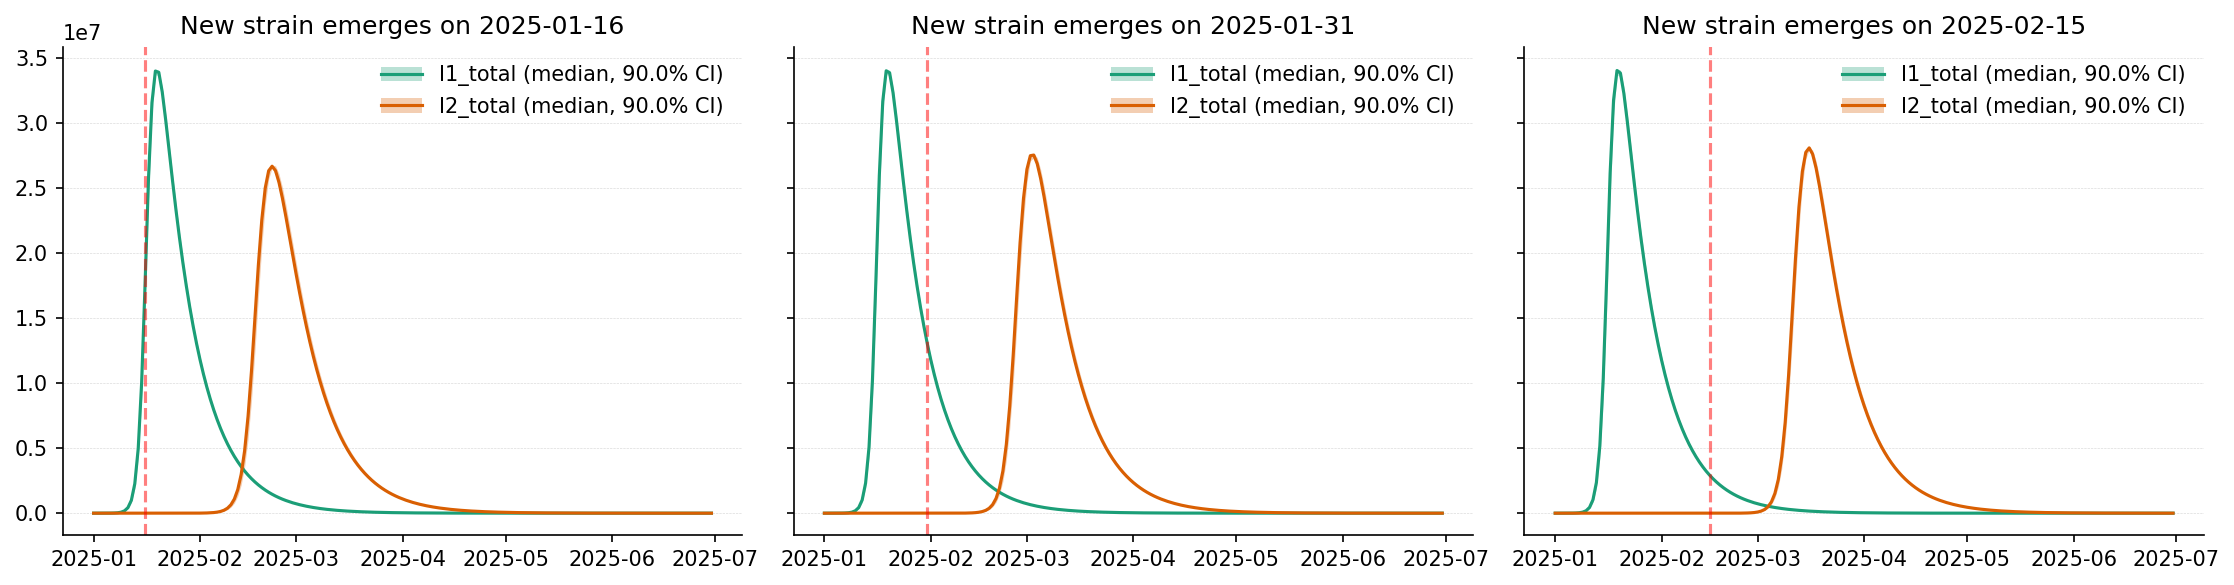

In [32]:
# Structure results for all 3 scenarios as quantiles
df_quantiles_early = results_early.get_quantiles_compartments()
df_quantiles_mid = results_mid.get_quantiles_compartments()
df_quantiles_late = results_late.get_quantiles_compartments()

# Visualize the three scenarios side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150, sharey=True)

# Plot each scenario
plot_quantiles(
    df_quantiles_early, ax = axes[0],
    columns = ['I1_total','I2_total'],
    title = f'New strain emerges on {date_early}',
    legend_loc = "upper right"
)
plot_quantiles(
    df_quantiles_mid, ax = axes[1],
    columns = ['I1_total','I2_total'],
    title = f'New strain emerges on {date_mid}',
    legend_loc = "upper right"
)
plot_quantiles(
    df_quantiles_late, ax = axes[2],
    columns = ['I1_total','I2_total'],
    title = f'New strain emerges on {date_late}',
    legend_loc = "upper right"
)

# Add new strain lines
axes[0].axvline(
    pd.to_datetime(date_early),
    color="red", linestyle="--", alpha=0.5,
    label="Strain 2 emerges"
)
axes[1].axvline(
    pd.to_datetime(date_mid),
    color="red", linestyle="--", alpha=0.5,
    label="Strain 2 emerges"
)
axes[2].axvline(
    pd.to_datetime(date_late),
    color="red", linestyle="--", alpha=0.5,
    label="Strain 2 emerges"
)

plt.tight_layout()

### Experiment B: Effect of Transmissibility Advantage

What if strain 2 is only 20% more transmissible (ψ = 1.2) vs 100% more transmissible (ψ = 2.0)?

In [ ]:
def run_with_psi(psi_value):
    """Run simulation with different transmissibility advantage."""
    # TODO: Create model with specified psi
    # TODO: Override parameters for first 30 days
    # TODO: Run simulations
    return ...

# TODO: Run with different psi values (1.2, 1.5, 2.0)
results_psi_low = ...
results_psi_mid = ...
results_psi_high = ...

In [ ]:
# TODO: Visualize the three psi scenarios side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150, sharey=True)

plt.tight_layout()

In [ ]:
# Optional: Compute when strain 2 becomes dominant
def compute_dominance_day(results):
    """Find the day when strain 2 exceeds strain 1."""
    traj = results.get_stacked_compartments()
    I1_median = np.median(traj["I1_total"], axis=0)
    I2_median = np.median(traj["I2_total"], axis=0)
    
    # Find first day where I2 > I1 (after emergence)
    crossover = np.where((I2_median > I1_median) & (I2_median > 100))[0]
    if len(crossover) > 0:
        return crossover[0]
    return None

# TODO: Print days until dominance for each psi value

## Discussion

*Write your observations here:*

1. **Emergence timing:** How does the timing of strain 2 emergence affect the dynamics? What happens when strain 1 has already infected a large portion of the population?

2. **Transmissibility advantage (ψ):** How does the transmissibility advantage affect the speed of strain replacement? At what ψ value does strain 2 fail to dominate?

3. **Cross-immunity (γ):** With γ = 0.4 (60% protection), how does this partial immunity affect the dynamics? What would happen with complete cross-protection (γ = 0)?

4. **Real-world implications:** What do these results suggest about variant emergence in real pandemics (e.g., SARS-CoV-2 Alpha, Delta, Omicron)?